# Binary Sentiment Analysis using Deep Learning models 

We use the following models:

1. Embeddings + Vanilla Neural Networks
2. Embeddings + CNN
3. Embeddings + LSTM

In [300]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, Dropout, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.utils import to_categorical
from keras.preprocessing import sequence

from keras.datasets import imdb

from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import re

%matplotlib inline

In [212]:
def plot_accuracy(hist):
    plt.plot(hist['acc'])
    plt.plot(hist['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 
                'test'], 
               loc='upper left')
    plt.show()
    
def plot_loss(hist):
    plt.plot(hist['loss'])
    plt.plot(hist['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 
                'test'], 
               loc='upper left')
    plt.show()    

In [213]:
df = pd.read_csv('movie_data.csv')

In [214]:
def preprocessor(text):
    text = re.sub('<[^>]*>', ' ', text)
    text = re.sub('[\W]+', ' ', text.lower())
    return text

In [215]:
#apply preprocessor to all reviews
df['review'] = df['review'].apply(preprocessor)

In [216]:
df.loc[0, 'review']

'my family and i normally do not watch local movies for the simple reason that they are poorly made they lack the depth and just not worth our time the trailer of nasaan ka man caught my attention my daughter in law s and daughter s so we took time out to watch it this afternoon the movie exceeded our expectations the cinematography was very good the story beautiful and the acting awesome jericho rosales was really very good so s claudine barretto the fact that i despised diether ocampo proves he was effective at his role i have never been this touched moved and affected by a local movie before imagine a cynic like me dabbing my eyes at the end of the movie congratulations to star cinema way to go jericho and claudine '

# BOW Model

In [217]:
all_tokenizer = Tokenizer()
all_tokenizer.fit_on_texts( df.review )

In [218]:
print("Documents: {}".format(all_tokenizer.document_count))
print("Unique Words: {}".format(len(all_tokenizer.word_counts)))

Documents: 50000
Unique Words: 101696


In [219]:
num_words = 30000
tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts( df.review )

In [220]:
print(tokenizer.word_index['the'])
print(tokenizer.word_index['movie'])

1
15


In [221]:
%%time
sequences = tokenizer.texts_to_sequences(df.review)

CPU times: user 7.47 s, sys: 164 ms, total: 7.64 s
Wall time: 7.76 s


## Truncating and padding the sequences

mean nmber of tokens: 232.26312
std of tokens: 171.44409155134392


Text(0,0.5,'fraction of reviews')

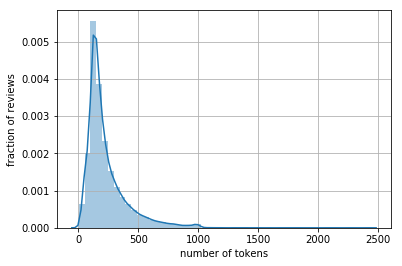

In [310]:
num_tokens = [len(tokens) for tokens in sequences]
num_tokens = np.array(num_tokens)
sn.distplot( num_tokens )
plt.grid(True)

mean_num_tokens = num_tokens.mean()
std_num_tokens = num_tokens.std()
print("mean nmber of tokens: {}".format(mean_num_tokens))
print("std of tokens: {}".format(std_num_tokens))
plt.xlabel('number of tokens')
plt.ylabel('fraction of reviews')

In [223]:
max_review_length = int(mean_num_tokens + 2.15 * std_num_tokens)
print("max length taken: {}".format(max_review_length))
print("untrimmed: {}".format(np.sum(num_tokens < max_review_length) / len(num_tokens)))

max length taken: 600
untrimmed: 0.95168


In [244]:
X = pad_sequences(sequences, 
                  max_review_length, 
                  padding='pre', 
                  truncating='pre')
Y = to_categorical(np.array(df.sentiment))
print(X.shape)

(50000, 600)


In [245]:
XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=0.5)

In [246]:
'''vocabulary_size = 20000
word_to_id = imdb.get_word_index()
(train_data, train_label), (test_data, test_label) = imdb.load_data(num_words = vocabulary_size)
id_to_word = {i: word for word,i in word_to_id.items()}'''

'vocabulary_size = 20000\nword_to_id = imdb.get_word_index()\n(train_data, train_label), (test_data, test_label) = imdb.load_data(num_words = vocabulary_size)\nid_to_word = {i: word for word,i in word_to_id.items()}'

In [247]:
'''max_words = 600
XTrain = sequence.pad_sequences(train_data, maxlen=max_words)
XTest = sequence.pad_sequences(test_data, maxlen=max_words)
YTrain = to_categorical(train_label)
YTest = to_categorical(test_label)'''

'max_words = 600\nXTrain = sequence.pad_sequences(train_data, maxlen=max_words)\nXTest = sequence.pad_sequences(test_data, maxlen=max_words)\nYTrain = to_categorical(train_label)\nYTest = to_categorical(test_label)'

In [251]:
embedding = 8

bow_model = Sequential()
bow_model.add(Embedding(num_words, embedding, input_length=max_review_length))
bow_model.add(Flatten())
bow_model.add(Dense(16, activation = 'relu'))
bow_model.add(Dropout(0.8))
bow_model.add(Dense(2, activation = 'softmax'))

bow_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

bow_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_41 (Embedding)     (None, 600, 8)            240000    
_________________________________________________________________
flatten_40 (Flatten)         (None, 4800)              0         
_________________________________________________________________
dense_120 (Dense)            (None, 16)                76816     
_________________________________________________________________
dropout_34 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_121 (Dense)            (None, 2)                 34        
Total params: 316,850
Trainable params: 316,850
Non-trainable params: 0
_________________________________________________________________


In [252]:
bow_history = bow_model.fit(
    XTrain, 
    YTrain,
    batch_size = 256,
    epochs = 10,
    validation_split = 0.2,
    verbose = True
)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 4s 200us/step - loss: 0.6937 - acc: 0.4968 - val_loss: 0.6931 - val_acc: 0.4992
Epoch 2/10
20000/20000 [==============================] - 2s 94us/step - loss: 0.6921 - acc: 0.5039 - val_loss: 0.6922 - val_acc: 0.5140
Epoch 3/10
20000/20000 [==============================] - 2s 89us/step - loss: 0.6667 - acc: 0.5758 - val_loss: 0.5530 - val_acc: 0.7704
Epoch 4/10
20000/20000 [==============================] - 2s 94us/step - loss: 0.4454 - acc: 0.8065 - val_loss: 0.3222 - val_acc: 0.8734
Epoch 5/10
20000/20000 [==============================] - 2s 101us/step - loss: 0.3114 - acc: 0.8751 - val_loss: 0.2828 - val_acc: 0.8824
Epoch 6/10
20000/20000 [==============================] - 2s 90us/step - loss: 0.2487 - acc: 0.9033 - val_loss: 0.2786 - val_acc: 0.8842
Epoch 7/10
20000/20000 [==============================] - 2s 93us/step - loss: 0.2122 - acc: 0.9202 - val_loss: 0.2963 - val_ac

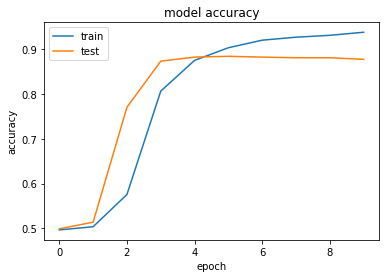

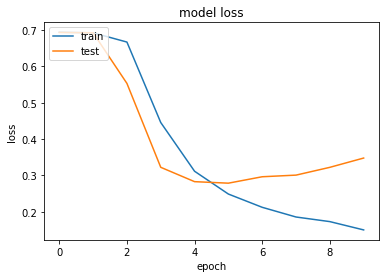

In [253]:
plot_accuracy(bow_history.history)
plot_loss(bow_history.history)

In [269]:
#confusion matrix
YPred = bow_model.predict_classes(XTest)

array([0, 1, 1, ..., 1, 1, 1])

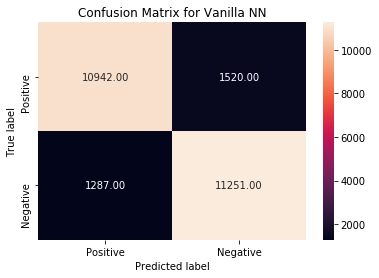

In [272]:
YPred = bow_model.predict_classes(XTest)
cm = metrics.confusion_matrix(np.argmax(YTest, axis=1),YPred)
sn.heatmap(cm, annot=True,  
           fmt='.2f', 
           xticklabels = ["Positive", "Negative"] , 
           yticklabels = ["Positive", "Negative"] )

plt.ylabel('True label')
plt.xlabel('Predicted label');
plt.title( 'Confusion Matrix for Vanilla NN');

## LSTM

In [297]:
embedding = 8
lstm_model = Sequential()
lstm_model.add(Embedding(num_words, embedding, input_length=max_review_length))
lstm_model.add(LSTM(100, activation='tanh'))
lstm_model.add(Dense(2, activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_50 (Embedding)     (None, 600, 8)            240000    
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               43600     
_________________________________________________________________
dense_129 (Dense)            (None, 2)                 202       
Total params: 283,802
Trainable params: 283,802
Non-trainable params: 0
_________________________________________________________________


In [298]:
lstm_history = lstm_model.fit(
    XTrain, 
    YTrain,
    batch_size = 256,
    epochs = 5,
    validation_split = 0.2,
    verbose = True
)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 146s 7ms/step - loss: 0.6698 - acc: 0.5869 - val_loss: 0.5303 - val_acc: 0.7478
Epoch 2/5
20000/20000 [==============================] - 148s 7ms/step - loss: 0.4581 - acc: 0.7921 - val_loss: 0.4649 - val_acc: 0.7872
Epoch 3/5
20000/20000 [==============================] - 142s 7ms/step - loss: 0.2652 - acc: 0.8935 - val_loss: 0.3405 - val_acc: 0.8550
Epoch 4/5
20000/20000 [==============================] - 140s 7ms/step - loss: 0.1739 - acc: 0.9366 - val_loss: 0.3769 - val_acc: 0.8628
Epoch 5/5
20000/20000 [==============================] - 142s 7ms/step - loss: 0.1205 - acc: 0.9610 - val_loss: 0.3574 - val_acc: 0.8458


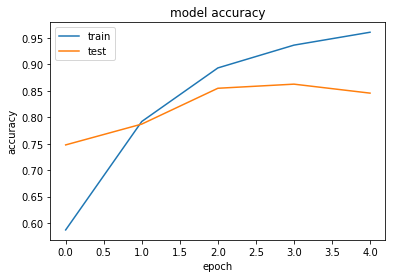

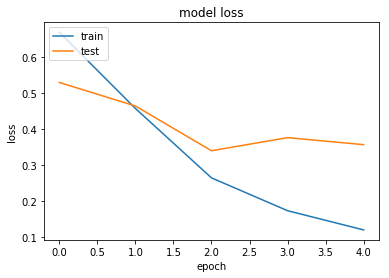

In [299]:
plot_accuracy(lstm_history.history)
plot_loss(lstm_history.history)

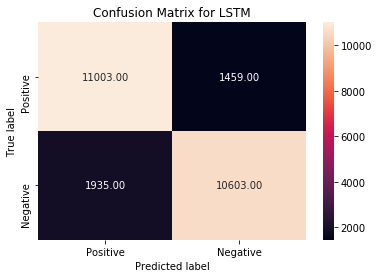

In [308]:
YPred = lstm_model.predict_classes(XTest)
cm = metrics.confusion_matrix(np.argmax(YTest, axis=1),YPred)
sn.heatmap(cm, annot=True,  
           fmt='.2f', 
           xticklabels = ["Positive", "Negative"] , 
           yticklabels = ["Positive", "Negative"] )

plt.ylabel('True label')
plt.xlabel('Predicted label');
plt.title( 'Confusion Matrix for LSTM');

## CNN

In [305]:
embedding = 8
cnn_model = Sequential()
cnn_model.add(Embedding(num_words, embedding, input_length=max_review_length))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(256,
                 3,
                 padding='valid',
                 activation='relu',
                strides=1))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(250, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(2, activation='softmax'))
cnn_model.compile(loss='categorical_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_55 (Embedding)     (None, 600, 8)            240000    
_________________________________________________________________
dropout_39 (Dropout)         (None, 600, 8)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 598, 256)          6400      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 256)               0         
_________________________________________________________________
dense_131 (Dense)            (None, 250)               64250     
_________________________________________________________________
dropout_40 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_132 (Dense)            (None, 2)                 502       
Total para

In [306]:
cnn_history = cnn_model.fit(
    XTrain, 
    YTrain,
    batch_size = 256,
    epochs = 5,
    validation_split = 0.2,
    verbose = True
)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 111s 6ms/step - loss: 0.6851 - acc: 0.5443 - val_loss: 0.6270 - val_acc: 0.6850
Epoch 2/5
20000/20000 [==============================] - 107s 5ms/step - loss: 0.4412 - acc: 0.7982 - val_loss: 0.3530 - val_acc: 0.8450
Epoch 3/5
20000/20000 [==============================] - 108s 5ms/step - loss: 0.2937 - acc: 0.8777 - val_loss: 0.3187 - val_acc: 0.8628
Epoch 4/5
20000/20000 [==============================] - 107s 5ms/step - loss: 0.2180 - acc: 0.9134 - val_loss: 0.3006 - val_acc: 0.8710
Epoch 5/5
20000/20000 [==============================] - 107s 5ms/step - loss: 0.1587 - acc: 0.9421 - val_loss: 0.3164 - val_acc: 0.8744


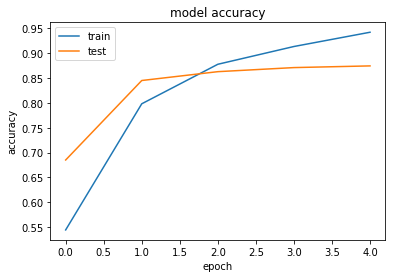

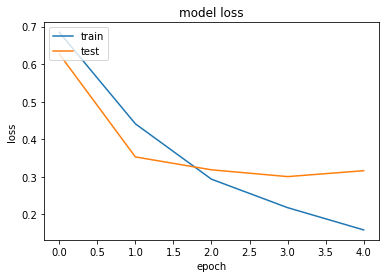

In [307]:
plot_accuracy(cnn_history.history)
plot_loss(cnn_history.history)

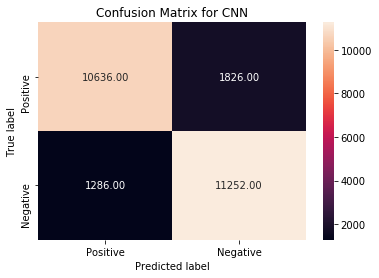

In [309]:
YPred = cnn_model.predict_classes(XTest)
cm = metrics.confusion_matrix(np.argmax(YTest, axis=1),YPred)
sn.heatmap(cm, annot=True,  
           fmt='.2f', 
           xticklabels = ["Positive", "Negative"] , 
           yticklabels = ["Positive", "Negative"] )

plt.ylabel('True label')
plt.xlabel('Predicted label');
plt.title( 'Confusion Matrix for CNN');